<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/unet_AB_8_portion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive

file_path = "/content/drive/MyDrive/Baumgartner screenshots/"

## Installing packages

In [7]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2
from skimage import color

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from sklearn.model_selection import train_test_split

## Defining functions

In [8]:
def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]
    crop_top = int((height - height / zoom_factor) / 2)# Calculate the region to crop around the center
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]    # Crop the image
    resized_image = cv2.resize(cropped_image, (width, height))# Resize the zoomed image back to the original dimensions
    return resized_image

def crop(im):
    width, height = im.size
    data = []
    step = int(size * 0.80)  # Adjust the step size for cropping
    for j in range(0, height, step):
        for i in range(0, width, step):
            if i + size <= width and j + size <= height:
                im1 = im.crop((i, j, i + size, j + size))
                im1 = np.array(im1).astype(np.float32)
                data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                for z in zoom_factor:
                    zoomed_img = zoom_and_resize(im1, z)
                    data.append(zoomed_img/255)
    return data

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def contrast_stretch(image):
    img_array = np.array(image)
    for i in range(3):  # 3 channels: Red, Green, Blue
        # Compute min and max pixel intensity values for the channel
        min_val = np.min(img_array[:,:,i])
        max_val = np.max(img_array[:,:,i])
        # Apply contrast stretching
        img_array[:,:,i] = (img_array[:,:,i] - min_val) * (255.0 / (max_val - min_val))
    # Convert numpy array back to PIL Image
    stretched_image = Image.fromarray(np.uint8(img_array))
    return stretched_image

## Preparing the training dataset

In [9]:
size = 8
model_number = size

zoom_factor = [1.5,2.0]
input = []
output = []

input_folder_path = file_path + 'Training/portion only/input_b/'
output_folder_path = file_path + 'Training/portion only/output_b/'

# List all files in the directory and sort them alphabetically
input_files = sorted(os.listdir(input_folder_path))
output_files = sorted(os.listdir(output_folder_path))

for image_file in input_files:
    image_path = os.path.join(input_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    input.extend(image)

for image_file in output_files:
    image_path = os.path.join(output_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    output.extend(image)
input = np.array(input)
output = np.array(output)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)



input = []
output = []

train_output = train_output[:,:,:,1:3]
train_input = train_input[:,:,:,1:3]
test_output = test_output[:,:,:,1:3]
test_input = test_input[:,:,:,1:3]

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

Done reading the input of size =  (22974, 8, 8, 3)
Done reading the output of size =  (22974, 8, 8, 3)
Done reading the train input of size =  (18379, 8, 8, 2)
Done reading the test input of size =  (4595, 8, 8, 2)
Done reading the train output of size =  (18379, 8, 8, 2)
Done reading the test output of size =  (4595, 8, 8, 2)


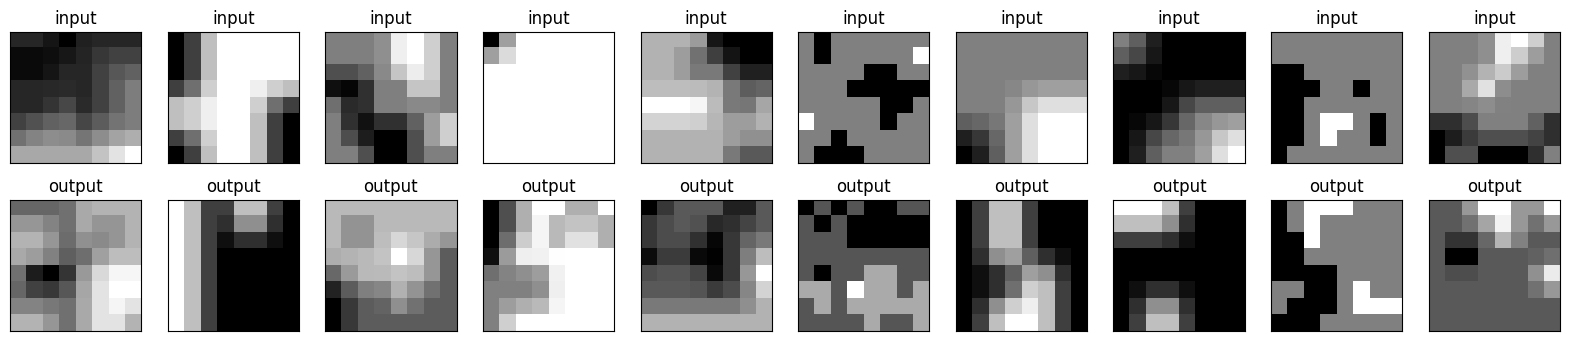

In [10]:
N = 500
n = 10
plt.figure(figsize=(20, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N][:,:,0]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N][:,:,0]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

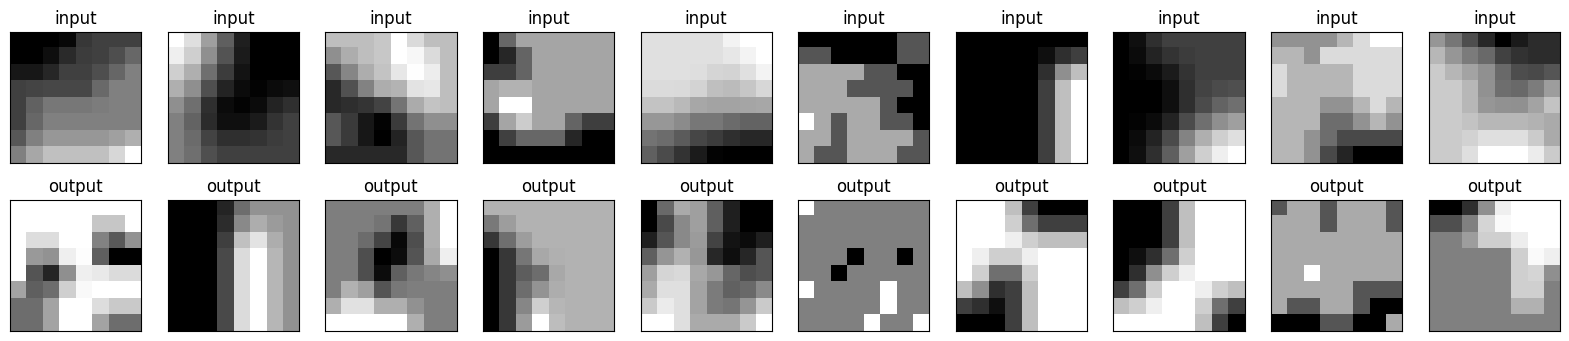

In [11]:
N = 500
n = 10
plt.figure(figsize=(20, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N][:,:,1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N][:,:,1]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Creating the Unet model

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def unet_model(input_shape=(size, size, 2)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    #conv3 = Conv2D(32, 3, activation='relu', padding='same', strides=2)(conv2)
    #conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)

    #conv4 = Conv2D(64, 3, activation='relu', padding='same', strides=2)(conv3)
    #conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    #conv5 = concatenate([Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv4), conv3], axis=-1)
    #conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    #conv6 = concatenate([Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv3), conv2], axis=-1)
    #conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)

    #conv7 = concatenate([Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2), conv1], axis=-1)
    #conv7 = Conv2D(8, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 2)]         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          608       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 2)           578       
                                                                 
Total params: 10434 (40.76 KB)
Trainable params: 10434 (40.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Unet model

In [13]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.001)
unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=100,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/portion only/unet_' + str(model_number) + '_ab')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'Model/portion only/loss_'+ str(model_number) + '_ab.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'Model/portion only/val_loss_'+ str(model_number)+ '_ab.csv')

Epoch 1/100
575/575 [==============================] - 7s 4ms/step - loss: 5.0194e-04 - val_loss: 2.8728e-04
Epoch 2/100
575/575 [==============================] - 2s 4ms/step - loss: 2.5801e-04 - val_loss: 2.2188e-04
Epoch 3/100
575/575 [==============================] - 3s 5ms/step - loss: 2.1928e-04 - val_loss: 1.8232e-04
Epoch 4/100
575/575 [==============================] - 2s 3ms/step - loss: 1.9371e-04 - val_loss: 1.7459e-04
Epoch 5/100
575/575 [==============================] - 2s 3ms/step - loss: 1.8178e-04 - val_loss: 1.8028e-04
Epoch 6/100
575/575 [==============================] - 2s 4ms/step - loss: 1.6845e-04 - val_loss: 1.5515e-04
Epoch 7/100
575/575 [==============================] - 2s 3ms/step - loss: 1.7263e-04 - val_loss: 1.4926e-04
Epoch 8/100
575/575 [==============================] - 2s 3ms/step - loss: 1.6783e-04 - val_loss: 1.6518e-04
Epoch 9/100
575/575 [==============================] - 3s 5ms/step - loss: 1.6216e-04 - val_loss: 1.6108e-04
Epoch 10/100
575/57

## Testing the model

6/6 [==============================] - 0s 9ms/step


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7bd330232320>)

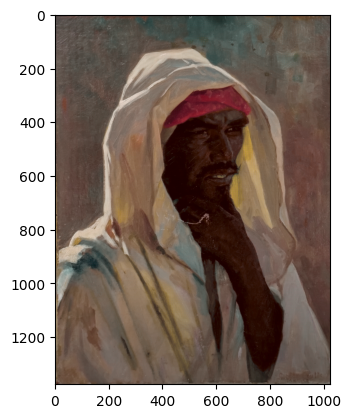

In [14]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

n_size = 8
size = n_size

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def AB_rgb_unnormalized(ab_image, test_L):
    ab_array = np.array(ab_image)/255# Convert LAB image to numpy array
    ab_array[..., 0] = (ab_array[..., 0] * 255.0) - 128
    ab_array[..., 1] = (ab_array[..., 1] * 255.0) - 128
    LAB_array = np.dstack((test_L, ab_array[:,:,0], ab_array[:,:,1]))
    rgb_array_unnormalized = color.lab2rgb(LAB_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            data.append(im1)
    return data



#----------------READING THE TEST IMAGE--------------------#
filename = str("[08] Conserving a Moroccan Portrait - Before.png")
test = Image.open(file_path+ "Testing/portion only/" + filename).convert('RGB')
test_L = color.rgb2lab(np.array(test))
test_L = np.array(test_L[..., 0]).astype('uint8')
test = rgb_lab_normalized(test)
#test = test[:,:,1:3]
#test = np.array(test).astype(np.float32)/255.0
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

autoencoder = keras.models.load_model(file_path + 'Model/portion only/unet_'+str(n_size)+'_ab')

xx = int(w_dirty/n_size)
final=[]
for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,1:3]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

#----------------TEST ON L from input and AB from model--------------------#
final.T
final_L_AB = AB_rgb_unnormalized(final, test_L)
final_L_AB = np.squeeze(final_L_AB)
reconstructed_L_AB = Image.fromarray(final_L_AB)
reconstructed_L_AB.save(file_path + "Testing/portion only/"+"Method_5_"+filename)
plt.figure(), plt.imshow(reconstructed_L_AB)